In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/CS613 Project/OASIS_alzheimer.zip' &> /dev/null

In [ ]:
!unzip '/content/drive/MyDrive/CS613 Project/64_LDA.zip' &> /dev/null
# !unzip '/content/drive/MyDrive/CS613 Project/128_LDA.zip' &> /dev/null

In [ ]:
!unzip '/content/drive/MyDrive/CS613 Project/64_Log.zip' &> /dev/null
# !unzip '/content/drive/MyDrive/CS613 Project/128_Log.zip' &> /dev/null

In [ ]:
from PIL import Image as I
from PIL import ImageFilter
import pandas as pd
import numpy as np
import os
import cv2
import shutil
import random
from distutils.file_util import copy_file
from statistics import mode
from sklearn.model_selection import train_test_split as split
from sklearn.metrics import confusion_matrix as cm
np.set_printoptions(suppress=True)

In [ ]:
non = '/content/Data/Non Demented'
vmild = '/content/Data/Very mild Dementia'
mild = '/content/Data/Mild Dementia'
mod = '/content/Data/Moderate Dementia'

In [ ]:
listmod = []
listnon = []
listvmild = []
listmild = []

for root, directories, files in os.walk(mod):
    for name in files:
        listmod.append(os.path.join(root, name))
for root, directories, files in os.walk(non):
    for name in files:
        listnon.append(os.path.join(root, name))
for root, directories, files in os.walk(vmild):
    for name in files:
        listvmild.append(os.path.join(root, name))
for root, directories, files in os.walk(mild):
    for name in files:
        listmild.append(os.path.join(root, name))

# Shuffle lists for random train / test
seed_value = 0
random.seed(seed_value)
random.shuffle(listmod)
random.shuffle(listnon)
random.shuffle(listvmild)
random.shuffle(listmild)

!mkdir ./Newdata
!mkdir ./Newdata/mildtrain
!mkdir ./Newdata/nontrain
!mkdir ./Newdata/vmildtrain
!mkdir ./Newdata/modtrain
!mkdir ./Newdata/mildtest
!mkdir ./Newdata/nontest
!mkdir ./Newdata/vmildtest
!mkdir ./Newdata/modtest

In [ ]:
pvmild = '/content/Newdata/vmildtrain'
pnon = '/content/Newdata/nontrain'
pmild = '/content/Newdata/mildtrain'
pmod = '/content/Newdata/modtrain'
tvmild = '/content/Newdata/vmildtest'
tnon = '/content/Newdata/nontest'
tmild = '/content/Newdata/mildtest'
tmod = '/content/Newdata/modtest'
n=488
for i in range(n):  #to get a balanced class prior, since lowest class count is 488
  if i<=(n*(2/3)):
      copy_file(listvmild[i], pvmild)
      copy_file(listmild[i], pmild)
      copy_file(listnon[i], pnon)
      copy_file(listmod[i], pmod)
  else:
    copy_file(listvmild[i], tvmild)
    copy_file(listmild[i], tmild)
    copy_file(listnon[i], tnon)
    copy_file(listmod[i], tmod)

TEST DATA PROCESSING FOR LDA AND LOG REG

In [ ]:
new_dir = [ tnon, tmild, tvmild, tmod ]

test_main_image_list = []
test_labels = []

for i in range(4):
    location = sorted( os.listdir( new_dir[i] ) )
    image_list = []
    label_list = []
    for file_name in location:
        file_path = os.path.join( new_dir[i] , file_name )
        image = I.open(file_path)

#########Blur
        # image = image.filter(ImageFilter.GaussianBlur(radius=2))

        new_image = image.convert('L').resize((64, 32)) #downsampling image for ease of computation
        image2D = np.array(new_image) #reading 2D matrix

#########Canny edge
        # image2D = cv2.Canny(image2D, 50, 150)

        image1D = image2D.flatten() #flattening to 1D matrix
        image_list.append(image1D)
        label_list.append(i)

    concatenated_images = np.vstack(image_list) #concatinating list vertically get 162xfeatures shape
    concatenated_labels = np.vstack(label_list)
    print(concatenated_images.shape)
    test_main_image_list.append(concatenated_images)
    test_labels.append(concatenated_labels)



test_main_image_list = np.vstack(test_main_image_list)
test_labels = np.vstack(test_labels)

tdata = np.concatenate((test_labels, test_main_image_list), axis=1)
test_df = pd.DataFrame(tdata)

test_df = test_df.sample(frac=1, random_state = 99)

X_test = test_df.iloc[:,1:].values
Y_test = test_df.iloc[:,:1].values

Y_test = Y_test.flatten()

(162, 2048)
(162, 2048)
(162, 2048)
(162, 2048)


LOADING LDA WEIGHTS

In [ ]:
means = np.load('/content/64_LDA_means.npy')
one_means = np.load('/content/64_LDA_one_means.npy')
zero_means = np.load('/content/64_LDA_zero_means.npy')
pcas = np.load('/content/64_LDA_pcas.npy')
weights = np.load('/content/64_LDA_weights.npy')

# means = np.load('/content/128_LDA_means.npy')
# one_means = np.load('/content/128_LDA_one_means.npy')
# zero_means = np.load('/content/128_LDA_zero_means.npy')
# pcas = np.load('/content/128_LDA_pcas.npy')
# weights = np.load('/content/128_LDA_weights.npy')

In [ ]:
list_num = [ [0,1], [0,2], [0,3], [1,2], [1,3], [2,3] ]
LDA_final_pred = []

for k in range ( np.shape(X_test)[0] ):
  result = []
  for l in range ( np.shape(weights)[0] ):

    X_test_k = (X_test[k] - means[l]) #ZERO-MEAN
    X_test_k = np.dot(X_test_k, pcas[l]) #PCA

    y_pred_val = np.dot(X_test_k, weights[l])

    a = abs(y_pred_val - zero_means[l])
    b = abs(y_pred_val - one_means[l])

    if a < b:
      final = list_num[l][0]
    else:
      final = list_num[l][1]

    result.append(final)

  LDA_final_pred.append(mode(result))

#accuracy
np.mean(Y_test == LDA_final_pred)

0.7561728395061729

LOADING LOG REG WEIGHTS

In [ ]:
gmeans = np.load('/content/64_Log_means.npy')
gstds = np.load('/content/64_Log_stds.npy')
gweights = np.load('/content/64_Log_weights.npy')

# gmeans = np.load('/content/128_Log_means.npy')
# gstds = np.load('/content/128_Log_stds.npy')
# gweights = np.load('/content/128_Log_weights.npy')

In [ ]:
list_num = [ [0,1], [0,2], [0,3], [1,2], [1,3], [2,3] ]
Log_final_pred = []

for k in range ( np.shape(X_test)[0] ):
  result = []
  for l in range ( np.shape(gweights)[0] ):

    X_test_k = (X_test[k] - gmeans[l]) / gstds[l] #ZSCORE

    z_val = np.dot(X_test_k, gweights[l])
    z_val = np.maximum(-1000, np.minimum(1000, z_val))
    y_pred_val = 1 / (1 + np.exp(-(z_val)))

    if y_pred_val > 0.5:
      final = list_num[l][1]
    else:
      final = list_num[l][0]

    result.append(final)

  Log_final_pred.append(mode(result))

#accuracy
np.mean(Y_test == Log_final_pred)

0.8194444444444444

PERFORMING KNN + CANNY

In [ ]:
new_dir = [ pnon, pmild, pvmild, pmod ]

main_image_list = []
labels = []

for i in range(4):
    location = sorted( os.listdir( new_dir[i] ) )
    image_list = []
    label_list = []
    for file_name in location:
        file_path = os.path.join( new_dir[i] , file_name )
        image = I.open(file_path)

#########Blur
        # image = image.filter(ImageFilter.GaussianBlur(radius=2))

        new_image = image.convert('L').resize((64, 32)) #downsampling image for ease of computation
        image2D = np.array(new_image) #reading 2D matrix

#########Canny edge
        image2D = cv2.Canny(image2D, 50, 150)

        image1D = image2D.flatten() #flattening to 1D matrix
        image_list.append(image1D)
        label_list.append(i)

    concatenated_images = np.vstack(image_list) #concatinating list vertically get 162xfeatures shape
    concatenated_labels = np.vstack(label_list)
    print(concatenated_images.shape)
    main_image_list.append(concatenated_images)
    labels.append(concatenated_labels)



main_image_list = np.vstack(main_image_list)
labels = np.vstack(labels)

data = np.concatenate((labels, main_image_list), axis=1)
train_df = pd.DataFrame(data)

train_df = train_df.sample(frac=1, random_state = 0)

X_train = train_df.iloc[:,1:].values
Y_train = train_df.iloc[:,:1].values

Y_train = Y_train.flatten()

(326, 2048)
(326, 2048)
(326, 2048)
(326, 2048)


In [ ]:
new_dir = [ tnon, tmild, tvmild, tmod ]

test_main_image_list = []
test_labels = []

for i in range(4):
    location = sorted( os.listdir( new_dir[i] ) )
    image_list = []
    label_list = []
    for file_name in location:
        file_path = os.path.join( new_dir[i] , file_name )
        image = I.open(file_path)

#########Blur
        # image = image.filter(ImageFilter.GaussianBlur(radius=2))

        new_image = image.convert('L').resize((64, 32)) #downsampling image for ease of computation
        image2D = np.array(new_image) #reading 2D matrix

#########Canny edge
        image2D = cv2.Canny(image2D, 50, 150)

        image1D = image2D.flatten() #flattening to 1D matrix
        image_list.append(image1D)
        label_list.append(i)

    concatenated_images = np.vstack(image_list) #concatinating list vertically get 162xfeatures shape
    concatenated_labels = np.vstack(label_list)
    print(concatenated_images.shape)
    test_main_image_list.append(concatenated_images)
    test_labels.append(concatenated_labels)



test_main_image_list = np.vstack(test_main_image_list)
test_labels = np.vstack(test_labels)

tdata = np.concatenate((test_labels, test_main_image_list), axis=1)
test_df = pd.DataFrame(tdata)

test_df = test_df.sample(frac=1, random_state = 99)

X_test = test_df.iloc[:,1:].values
Y_test = test_df.iloc[:,:1].values

Y_test = Y_test.flatten()

(162, 2048)
(162, 2048)
(162, 2048)
(162, 2048)


In [ ]:
K = 5
s = X_test.shape[0]
t = X_train.shape[0]
KNN_final_pred = np.zeros(s)
for i in range(s):
    similar = np.zeros(t)
    for j in range(t):
        t_min = np.minimum(X_test[i, :], X_train[j, :])
        sim = np.sum(t_min)
        similar[j] = sim
    sorted_index = np.argsort(similar)[::-1]
    knn_index = sorted_index[:K]
    knn_label = Y_train[knn_index]
    KNN_final_pred[i] = np.bincount(knn_label).argmax()

#accuracy
np.mean(Y_test == KNN_final_pred)

0.7191358024691358

In [ ]:
KNN_final_pred = KNN_final_pred.astype(int).tolist()

**Ensemble by Voting**

In [ ]:
LDA_onehot = np.zeros((Y_test.size,4))
for i in range( Y_test.size ):
  LDA_onehot[i][ LDA_final_pred[i] ] = 1
LDA_onehot

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [ ]:
Log_onehot = np.zeros((Y_test.size,4))
for i in range( Y_test.size ):
  Log_onehot[i][ Log_final_pred[i] ] = 1
Log_onehot

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [ ]:
KNN_onehot = np.zeros((Y_test.size,4))
for i in range( Y_test.size ):
  KNN_onehot[i][ KNN_final_pred[i] ] = 1
KNN_onehot

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
weighted_mean = ( LDA_onehot + Log_onehot + KNN_onehot )/ 3
weighted_mean

array([[0.        , 1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       ...,
       [0.33333333, 0.66666667, 0.        , 0.        ],
       [0.66666667, 0.        , 0.        , 0.33333333],
       [0.        , 0.        , 0.        , 1.        ]])

In [ ]:
b = np.argmax(weighted_mean, axis = 1)
a = np.mean(Y_test == b)

In [ ]:
p = 0
r = 0

for i in range(4):
    tp = np.sum((b == i) & (Y_test == i))
    tn = np.sum((b != i) & (Y_test != i))
    fp = np.sum((b == i) & (Y_test != i))
    fn = np.sum((b != i) & (Y_test == i))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    p = p + precision
    r = r + recall

p = p/4
r = r/4
f1 = (2*p*r) / (p+r)

In [ ]:
print('Ensemble Accuracy  for 64x32:', a)
print('Ensemble Precision for 64x32:', p)
print('Ensemble Recall    for 64x32:', r)
print('Ensemble F1-score  for 64x32:', f1)

Ensemble Accuracy  for 64x32: 0.8271604938271605
Ensemble Precision for 64x32: 0.8357151653550845
Ensemble Recall    for 64x32: 0.8271604938271605
Ensemble F1-score  for 64x32: 0.8314158248174803


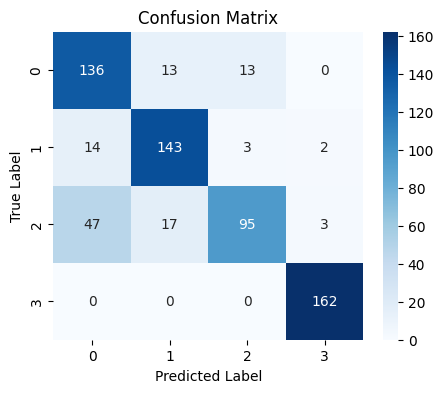

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
cm1 = cm(Y_test, b)

# Plot the confusion matrix with a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()